# Import necessary libraries

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    mean_squared_error,
)
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt

# Dict of inputs and outputs with default values

In [24]:
inputs = {
    'DataFrame': None,  
    'Classifier_model':'KNN',
    'test_size': 0.2,  
    'n_estimators': 100,  # Number of trees in RandomForest
    'max_depth': 10,  # Maximum depth of RandomForest trees
    'C': 1.0,  # Regularization parameter for SVC
    'kernel': 'rbf',  # Kernel type for SVC
    'gamma': 'scale',  # Kernel coefficient for SVC
    'n_neighbors': 5,  # Number of neighbors for KNN
    'weights': 'uniform',  # Weight function for KNN
    'metric': 'euclidean',  # Distance metric for KNN
    'p': 2,  # Power parameter for Minkowski distance (KNN)
    'use_defaults':1  # Flag to enable or disable grid search
}

outputs = {
    'accuracy': None, 
    'report': None,  
    'cm': None,  
    'mse': None 
}


# BaseClass 
EvaluationClassifier

In [25]:
class CarEvaluationClassifier:
    def __init__(self, DataFrame, test_size=inputs['test_size']):
        self.encoder = LabelEncoder()

        # Encode all columns
        for column in DataFrame.columns:
            DataFrame[column] = DataFrame[column].astype(str)
            DataFrame[column] = self.encoder.fit_transform(DataFrame[column])

        self.data = DataFrame.iloc[:, :-1]
        self.target = DataFrame.iloc[:, -1]

        self.prepare_data(test_size)

    def prepare_data(self, test_size=inputs['test_size']):
        self.data_train, self.data_test, self.target_train, self.target_test = train_test_split(
            self.data, self.target, test_size=test_size, random_state=42
        )

    def set_model(self, model):
        self.current_model = model
        print(f"Model set to: {type(model).__name__}")

    def evaluate(self, target_test=None, target_pred=None):
        if target_test is None:
            target_test = self.target_test
        if target_pred is None:
            target_pred = self.target_pred

        accuracy = accuracy_score(target_test, target_pred)
        report = classification_report(target_test, target_pred)
        cm = confusion_matrix(target_test, target_pred)
        mse = mean_squared_error(target_test, target_pred)

        # Save outputs to the dictionary
        outputs['accuracy'] = accuracy
        outputs['report'] = report
        outputs['cm'] = cm
        outputs['mse'] = mse

        print("Model Accuracy:", accuracy)
        print("\nClassification Report:\n", report)
        print("\nConfusion Matrix:")
        print(cm)
        print(f"Mean Squared Error: {mse:.4f}")

        return accuracy, report, cm, mse

    def display_confusion_matrix(self, cm=None):
        if cm is None:
            cm = confusion_matrix(self.target_test, self.target_pred)

        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues")
        plt.title("Confusion Matrix")
        plt.show()

## Child Class RandomForestModel


In [26]:
class RandomForestModel(CarEvaluationClassifier):
    def __init__(self, DataFrame, test_size=inputs['test_size']):
        super().__init__(DataFrame, test_size)
        self.use_grid_search = bool(inputs['use_defaults'])
        self.param_grid = {
            'n_estimators': [50, 100, 150],
            'max_depth': [5, 10, 20]
        }
        self.model = RandomForestClassifier(
            n_estimators=inputs['n_estimators'],
            max_depth=inputs['max_depth'],
            random_state=42
        )

    def train(self):
        if self.use_grid_search:
            grid_search = GridSearchCV(RandomForestClassifier(random_state=42), self.param_grid, cv=3, scoring='accuracy')
            grid_search.fit(self.data_train, self.target_train)
            self.model = grid_search.best_estimator_
            print(f"Best parameters for RandomForest: {grid_search.best_params_}")
        else:
            self.model.fit(self.data_train, self.target_train)
            print("Training complete with RandomForest using input parameters.")

        self.target_pred = self.model.predict(self.data_test)

## Child Class SVCModel

In [27]:
class SVCModel(CarEvaluationClassifier):
    def __init__(self, DataFrame, test_size=inputs['test_size']):
        super().__init__(DataFrame, test_size)
        self.use_grid_search = bool(inputs['use_defaults'])
        self.param_grid = {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
        self.model = SVC(
            C=inputs['C'],
            kernel=inputs['kernel'],
            gamma=inputs['gamma']
        )

    def train(self):
        if self.use_grid_search:
            grid_search = GridSearchCV(SVC(), self.param_grid, cv=3, scoring='accuracy')
            grid_search.fit(self.data_train, self.target_train)
            self.model = grid_search.best_estimator_
            print(f"Best parameters for SVC: {grid_search.best_params_}")
        else:
            self.model.fit(self.data_train, self.target_train)
            print("Training complete with SVC using input parameters.")

        self.target_pred = self.model.predict(self.data_test)

## Child Class KNNModel

In [28]:
class KNNModel(CarEvaluationClassifier):
    def __init__(self, DataFrame, test_size=inputs['test_size']):
        super().__init__(DataFrame, test_size)
        self.use_grid_search = bool(inputs['use_defaults'])
        self.param_grid = {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
        self.model = KNeighborsClassifier(
            n_neighbors=inputs['n_neighbors'],
            weights=inputs['weights'],
            metric=inputs['metric'],
            p=inputs['p']
        )

    def train(self):
        if self.use_grid_search:
            grid_search = GridSearchCV(KNeighborsClassifier(metric='minkowski'), self.param_grid, cv=3, scoring='accuracy')
            grid_search.fit(self.data_train, self.target_train)
            self.model = grid_search.best_estimator_
            print(f"Best parameters for KNN: {grid_search.best_params_}")
        else:
            self.model.fit(self.data_train, self.target_train)
            print("Training complete with KNN using input parameters.")

        self.target_pred = self.model.predict(self.data_test)


Instance 

Available models: RandomForest, SVC, KNN
Best parameters for KNN: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Model Accuracy: 0.930635838150289

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.78      0.85        83
           1       1.00      0.73      0.84        11
           2       0.93      1.00      0.96       235
           3       0.94      0.88      0.91        17

    accuracy                           0.93       346
   macro avg       0.95      0.85      0.89       346
weighted avg       0.93      0.93      0.93       346


Confusion Matrix:
[[ 65   0  18   0]
 [  2   8   0   1]
 [  1   0 234   0]
 [  2   0   0  15]]
Mean Squared Error: 0.2890


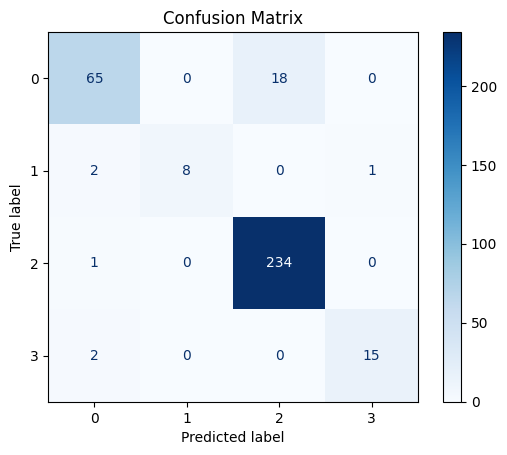

In [29]:
# Load the data
filepath = "car.data"
data = pd.read_csv(filepath, header=None)

# User selects a model
print("Available models: RandomForest, SVC, KNN")
selected_model = inputs['Classifier_model']

# Create and use the selected model
try:
    if selected_model == "RandomForest":
        model = RandomForestModel(data)
    elif selected_model == "SVC":
        model = SVCModel(data)
    elif selected_model == "KNN":
        model = KNNModel(data)
    else:
        raise ValueError("Invalid model name entered.")

    model.prepare_data()
    model.train()
    accuracy, report, cm, mse = model.evaluate()
    model.display_confusion_matrix(cm)

except ValueError as e:
    print(e)
